# Pure FNO (NeuralOperator) — 1D x(t) → y(t) training notebook (leakage-safe)

This notebook trains a **pure FNO-1D** to learn **x(t) → y(t)**.

Key fixes / features:
- **Train/Val/Test split happens BEFORE preprocessing**.
- **Normalization stats are computed using TRAIN ONLY** (prevents data leakage).
- Optional preprocessing toggles:
  - `remove_dc` (subtract mean per-sample)
  - `normalize` (`none` / `standard` / `maxabs`) — train-only stats
  - `per_sample_rms` (optional)
  - `add_time_channel` (adds a normalized time coordinate to **X only**)
- Quick sanity checks include:
  - time-domain plot
  - **linear** FFT magnitude (no semilogy)
  - phase (wrapped) + **phase difference** (masked where magnitude is tiny)

Assumption: your segment is **0.3 seconds** (e.g., [0, 0.3] s).  
If `T=57600`, then `fs = 57600 / 0.3 = 192000 Hz`.


## 0) Setup

In [60]:

# If needed (fresh env), uncomment:
# !pip -q install neuraloperator torch numpy scipy matplotlib tqdm soundfile

import os, json, random, math
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch: 2.5.1
CUDA: True


device(type='cuda')

## 1) Load data

Choose one:
- **Option A (recommended)**: `.npz` with arrays `X` and `Y`
  - `X`: `[N,T]` or `[N,C_in,T]`
  - `Y`: `[N,T]` or `[N,C_out,T]`
- **Option B**: paired WAV folders (`x_dir`, `y_dir`) matched by filename stem


In [61]:

def ensure_3d(arr: np.ndarray) -> np.ndarray:
    """Convert to [N, C, T]. Accepts [N,T] or [N,C,T]."""
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return arr[:, None, :]
    if arr.ndim == 3:
        return arr
    raise ValueError(f"Expected 2D or 3D array, got shape {arr.shape}")

def load_npz(npz_path: str, x_key="X", y_key="Y") -> Tuple[np.ndarray, np.ndarray, Dict]:
    npz = np.load(npz_path, allow_pickle=True)
    X = ensure_3d(npz[x_key]).astype(np.float32)
    Y = ensure_3d(npz[y_key]).astype(np.float32)
    meta = {}
    for k in npz.files:
        if k not in (x_key, y_key):
            try:
                meta[k] = npz[k].item() if npz[k].dtype == object else npz[k]
            except Exception:
                pass
    return X, Y, meta

def load_wav_pairs(x_dir: str, y_dir: str, sr_expected: Optional[int]=None) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """Load paired wav files from x_dir and y_dir. Matching is by filename stem."""
    try:
        import soundfile as sf
        def read_fn(p):
            data, sr = sf.read(p, dtype="float32")
            return sr, data
    except Exception:
        from scipy.io import wavfile
        def read_fn(p):
            sr, data = wavfile.read(p)
            data = data.astype(np.float32)
            if data.dtype.kind in ("i", "u"):
                maxv = np.iinfo(data.dtype).max
                data = data / maxv
            return sr, data

    x_dir = Path(x_dir)
    y_dir = Path(y_dir)
    x_files = sorted(x_dir.glob("*.wav"))
    if not x_files:
        raise FileNotFoundError(f"No wav files found in {x_dir}")

    y_map = {p.stem: p for p in y_dir.glob("*.wav")}
    pairs = [(xf, y_map.get(xf.stem)) for xf in x_files if xf.stem in y_map]
    if not pairs:
        raise FileNotFoundError("No matching wav stems found between x_dir and y_dir.")

    X_list, Y_list = [], []
    sr0 = None
    for xf, yf in tqdm(pairs, desc="Loading WAV pairs"):
        sr_x, x = read_fn(str(xf))
        sr_y, y = read_fn(str(yf))
        if sr_x != sr_y:
            raise ValueError(f"Sample rate mismatch for {xf.name}: x={sr_x}, y={sr_y}")
        if sr0 is None:
            sr0 = sr_x
        if sr_expected is not None and sr_x != sr_expected:
            raise ValueError(f"Expected sr={sr_expected}, got {sr_x} for {xf.name}")

        x = np.asarray(x).squeeze()
        y = np.asarray(y).squeeze()
        if x.ndim > 1: x = x[:, 0]
        if y.ndim > 1: y = y[:, 0]

        X_list.append(x[None, :])
        Y_list.append(y[None, :])

    T = min(min(a.shape[-1] for a in X_list), min(b.shape[-1] for b in Y_list))
    X = np.stack([a[..., :T] for a in X_list], axis=0).astype(np.float32)
    Y = np.stack([b[..., :T] for b in Y_list], axis=0).astype(np.float32)

    meta = {"sample_rate": int(sr0), "T": int(T), "N": int(X.shape[0])}
    return X, Y, meta

USE_LOADER = "wav"  # "npz" or "wav"

NPZ_PATH = "./data_xy.npz"   # <-- change

X_WAV_DIR = "./data/x_t"       # <-- change
Y_WAV_DIR = "./data/y_t"      # <-- change
SR_EXPECTED = None           # e.g., 48000

if USE_LOADER == "npz":
    X, Y, meta = load_npz(NPZ_PATH, x_key="X", y_key="Y")
else:
    X, Y, meta = load_wav_pairs(X_WAV_DIR, Y_WAV_DIR, sr_expected=SR_EXPECTED)

print("Loaded:")
print("  X:", X.shape, X.dtype)
print("  Y:", Y.shape, Y.dtype)
print("  meta keys:", list(meta.keys()))


Loading WAV pairs: 100%|██████████| 2322/2322 [00:11<00:00, 209.85it/s]


Loaded:
  X: (2322, 1, 57600) float32
  Y: (2322, 1, 57600) float32
  meta keys: ['sample_rate', 'T', 'N']


## 2) Resolve sample rate and duration

In [62]:
# --- Step 2) Resolve sample rate and duration (+ optional resampling to 48k) ---
from scipy.signal import resample_poly

SEG_DUR_SEC = 0.3         # you said data is [0, 0.3] sec
TARGET_FS   = 48000       # resample target

# 1) resolve fs_in
T_in = X.shape[-1]
if "sample_rate" in meta:
    fs_in = int(meta["sample_rate"])
    print("fs_in from meta:", fs_in)
else:
    fs_in = int(round(T_in / SEG_DUR_SEC))
    print("fs_in inferred from T/duration:", fs_in)

print("Before resample:")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs_in:", fs_in, "duration:", T_in / fs_in, "sec")

# 2) resample if needed (vectorized over axis=-1)
if fs_in != TARGET_FS:
    g = math.gcd(fs_in, TARGET_FS)
    up = TARGET_FS // g
    down = fs_in // g
    print(f"Resampling: {fs_in} -> {TARGET_FS} (up={up}, down={down})")

    # [N, C, T] resampling along time axis
    X = resample_poly(X, up, down, axis=-1).astype(np.float32)
    Y = resample_poly(Y, up, down, axis=-1).astype(np.float32)

    meta["sample_rate"] = TARGET_FS

# 3) final fs and duration
fs = int(meta["sample_rate"]) if "sample_rate" in meta else TARGET_FS
T = X.shape[-1]

print("After resample:")
print("  X:", X.shape, "Y:", Y.shape)
print("  fs:", fs, "duration:", T / fs, "sec")

# After resample, before split
KEEP_FRAC = 0.1  # 1/5
T = X.shape[-1]
T_keep = int(T * KEEP_FRAC)

X = X[..., :T_keep]
Y = Y[..., :T_keep]

print("Cropped:")
print("  T_keep:", T_keep, "duration:", T_keep / fs, "sec")

fs_in from meta: 192000
Before resample:
  X: (2322, 1, 57600) Y: (2322, 1, 57600)
  fs_in: 192000 duration: 0.3 sec
Resampling: 192000 -> 48000 (up=1, down=4)
After resample:
  X: (2322, 1, 14400) Y: (2322, 1, 14400)
  fs: 48000 duration: 0.3 sec
Cropped:
  T_keep: 1440 duration: 0.03 sec


## 3) Train/Val/Test split (BEFORE preprocessing)

This is critical for leakage-safe normalization.


In [63]:

@dataclass
class SplitConfig:
    seed: int = 42
    frac_train: float = 0.8
    frac_val: float = 0.1
    batch_size: int = 16
    num_workers: int = 0
    pin_memory: bool = True

cfg_split = SplitConfig(batch_size=16)

N = X.shape[0]
rng = np.random.default_rng(cfg_split.seed)
idx = np.arange(N)
rng.shuffle(idx)

n_train = int(cfg_split.frac_train * N)
n_val   = int(cfg_split.frac_val   * N)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]
X_test,  Y_test  = X[test_idx],  Y[test_idx]

print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))


Split sizes: 1857 232 233


## 4) Preprocessing (train-only stats)

Order:
1) remove DC per-sample (optional)
2) per-sample RMS normalization (optional)
3) dataset-level normalization using **TRAIN stats only** (optional)
4) add time channel to **X only** (optional)


In [64]:

@dataclass
class PreprocConfig:
    remove_dc: bool = True
    per_sample_rms: bool = False
    normalize: str = "standard"  # "none" | "standard" | "maxabs"
    add_time_channel: bool = True
    eps: float = 1e-8

cfg_prep = PreprocConfig(
    remove_dc=False,
    per_sample_rms=False,
    normalize="none",
    add_time_channel=True
)

def remove_dc_per_sample(A: np.ndarray) -> np.ndarray:
    return A - A.mean(axis=-1, keepdims=True)

def rms_per_sample(A: np.ndarray, eps=1e-8) -> np.ndarray:
    rms = np.sqrt(np.mean(A**2, axis=-1, keepdims=True) + eps)
    return A / rms

def compute_norm_stats_train_only(Xtr: np.ndarray, Ytr: np.ndarray, mode: str, eps: float=1e-8):
    if mode == "none":
        return None
    if mode == "standard":
        x_mean = Xtr.mean(axis=(0,2), keepdims=True)
        x_std  = Xtr.std(axis=(0,2), keepdims=True) + eps
        y_mean = Ytr.mean(axis=(0,2), keepdims=True)
        y_std  = Ytr.std(axis=(0,2), keepdims=True) + eps
        return {"mode": mode, "x_mean": x_mean, "x_std": x_std, "y_mean": y_mean, "y_std": y_std}
    if mode == "maxabs":
        x_scale = np.max(np.abs(Xtr), axis=(0,2), keepdims=True) + eps
        y_scale = np.max(np.abs(Ytr), axis=(0,2), keepdims=True) + eps
        return {"mode": mode, "x_scale": x_scale, "y_scale": y_scale}
    raise ValueError(f"Unknown normalize mode: {mode}")

def apply_dataset_norm(Xa: np.ndarray, Ya: np.ndarray, stats: Optional[dict]):
    if stats is None or stats.get("mode") == "none":
        return Xa, Ya
    if stats["mode"] == "standard":
        Xn = (Xa - stats["x_mean"]) / stats["x_std"]
        Yn = (Ya - stats["y_mean"]) / stats["y_std"]
        return Xn, Yn
    if stats["mode"] == "maxabs":
        return Xa / stats["x_scale"], Ya / stats["y_scale"]
    raise ValueError("Bad stats dict")

def add_time_channel(Xa: np.ndarray) -> np.ndarray:
    N, C, T = Xa.shape
    t = np.linspace(0.0, 0.3, T, dtype=np.float32)[None, None, :]
    t = np.repeat(t, N, axis=0)
    return np.concatenate([Xa, t], axis=1)

def preprocess_split(Xa: np.ndarray, Ya: np.ndarray, cfg: PreprocConfig, stats: Optional[dict]):
    Xp, Yp = Xa.copy(), Ya.copy()

    if cfg.remove_dc:
        Xp = remove_dc_per_sample(Xp)
        Yp = remove_dc_per_sample(Yp)

    if cfg.per_sample_rms:
        Xp = rms_per_sample(Xp, eps=cfg.eps)
        Yp = rms_per_sample(Yp, eps=cfg.eps)

    Xp, Yp = apply_dataset_norm(Xp, Yp, stats)

    if cfg.add_time_channel:
        Xp = add_time_channel(Xp)

    return Xp.astype(np.float32), Yp.astype(np.float32)

# ---- train-only stats computed on train after optional per-sample transforms ----
X_train_tmp, Y_train_tmp = X_train.copy(), Y_train.copy()
if cfg_prep.remove_dc:
    X_train_tmp = remove_dc_per_sample(X_train_tmp)
    Y_train_tmp = remove_dc_per_sample(Y_train_tmp)
if cfg_prep.per_sample_rms:
    X_train_tmp = rms_per_sample(X_train_tmp, eps=cfg_prep.eps)
    Y_train_tmp = rms_per_sample(Y_train_tmp, eps=cfg_prep.eps)

norm_stats = compute_norm_stats_train_only(X_train_tmp, Y_train_tmp, cfg_prep.normalize, eps=cfg_prep.eps)

X_train_n, Y_train_n = preprocess_split(X_train, Y_train, cfg_prep, norm_stats)
X_val_n,   Y_val_n   = preprocess_split(X_val,   Y_val,   cfg_prep, norm_stats)
X_test_n,  Y_test_n  = preprocess_split(X_test,  Y_test,  cfg_prep, norm_stats)

print("After preprocessing:")
print("  X_train_n:", X_train_n.shape, X_train_n.dtype)
print("  Y_train_n:", Y_train_n.shape, Y_train_n.dtype)


After preprocessing:
  X_train_n: (1857, 2, 1440) float32
  Y_train_n: (1857, 1, 1440) float32


## 5) Quick sanity checks (linear magnitude + phase)

- magnitude: **linear**
- phase: wrapped degrees in [-180, 180]
- mask phase where magnitude is below (max + `mag_floor_db`)
- show phase difference: ∠(Y·conj(X))


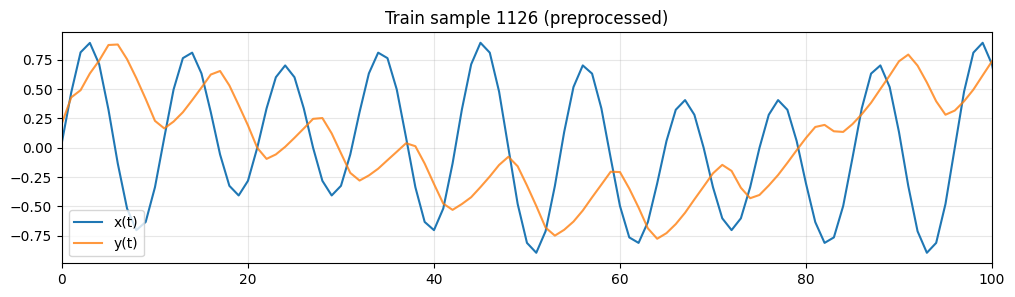

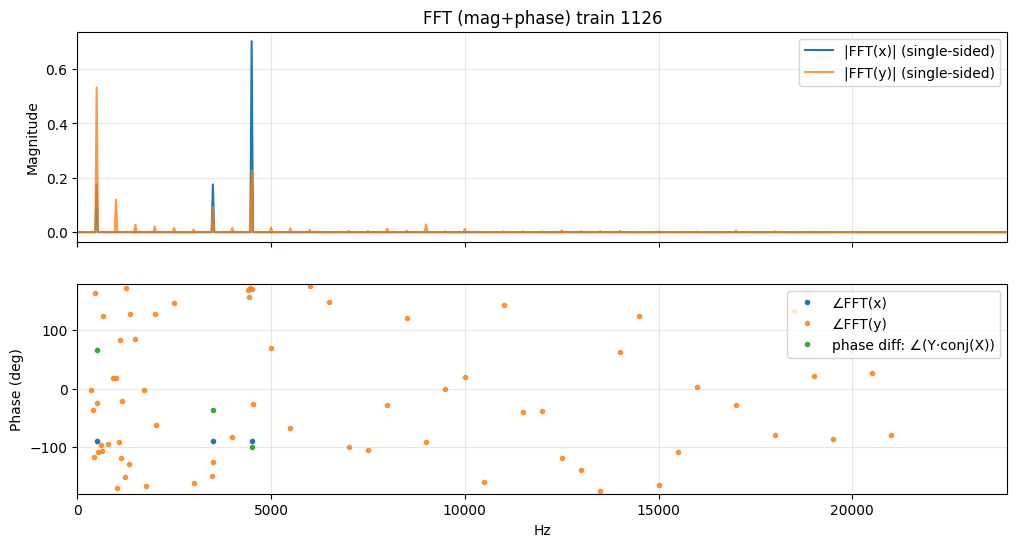

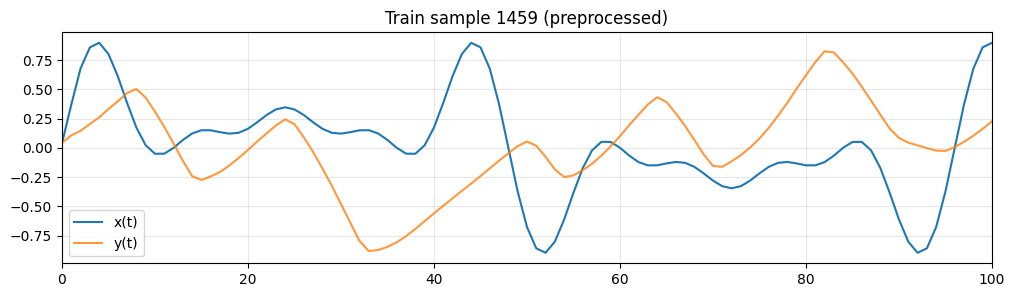

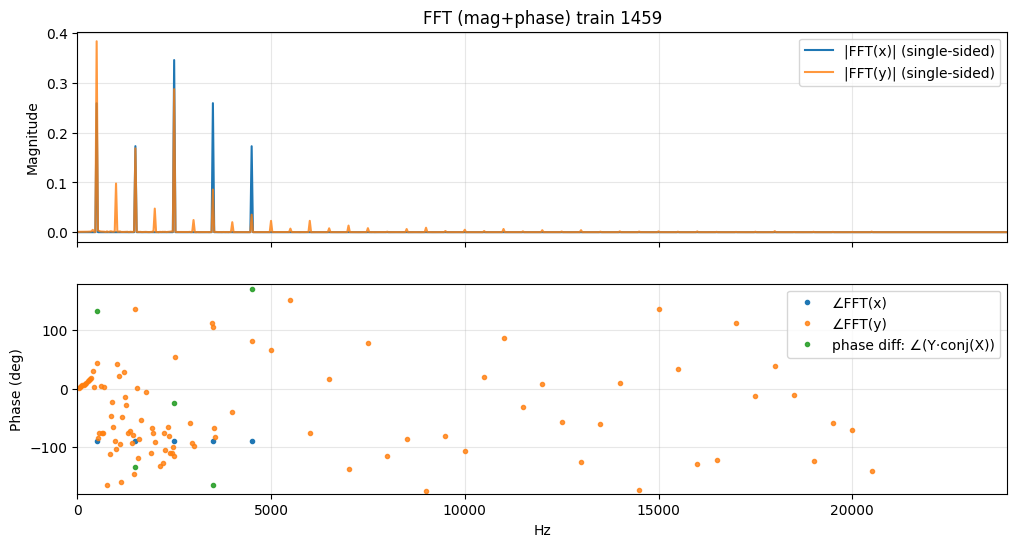

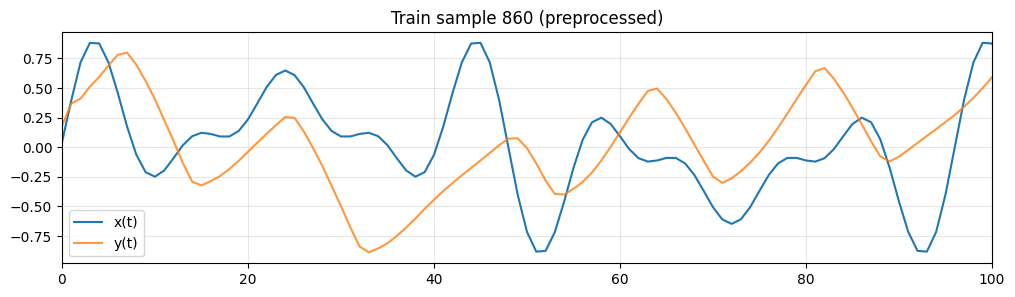

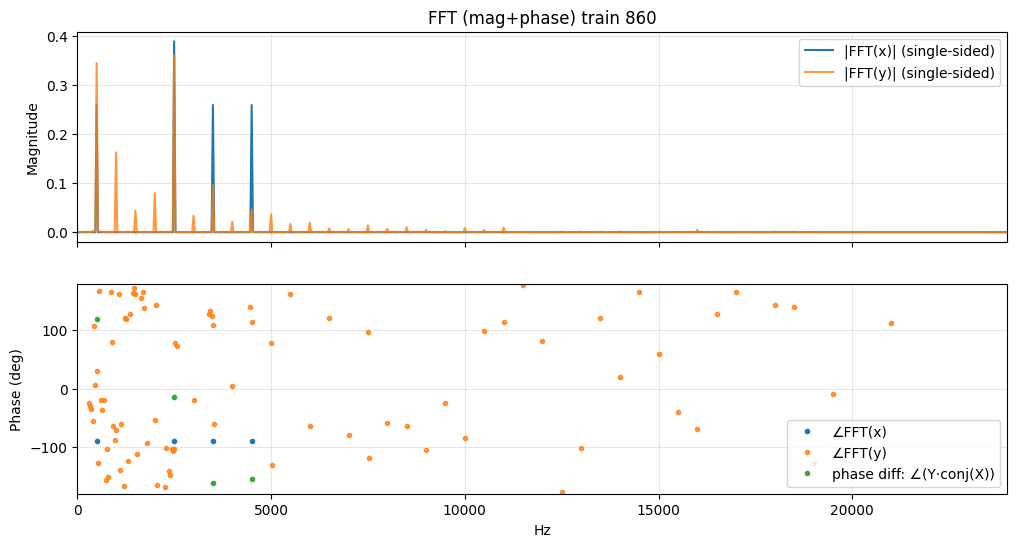

In [65]:

def plot_sample_xy(Xa, Ya, idx=0, title=None, max_points=6000, t_xlim_samples=2000):
    x = Xa[idx, 0]
    y = Ya[idx, 0]
    T = x.shape[-1]
    step = max(1, T // max_points)

    plt.figure(figsize=(12, 3))
    plt.plot(x[::step], label="x(t)")
    plt.plot(y[::step], label="y(t)", alpha=0.8)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if title:
        plt.title(title)
    # x-axis is sample index after downsample
    # plt.xlim(0, min(t_xlim_samples, T//step))
    plt.xlim(0, 100)
    plt.show()

def plot_fft_mag_phase_linear(x, y, fs, title=None, f_xlim=24000, mag_floor_db=-60, show_phase_diff=True):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    N = len(x)

    Xf = np.fft.rfft(x)
    Yf = np.fft.rfft(y)
    f  = np.fft.rfftfreq(N, d=1.0/fs)

    magX = np.abs(Xf) / N
    magY = np.abs(Yf) / N
    if magX.size > 2:
        magX[1:-1] *= 2
        magY[1:-1] *= 2

    phX = np.rad2deg(np.angle(Xf))
    phY = np.rad2deg(np.angle(Yf))
    if show_phase_diff:
        phD = np.rad2deg(np.angle(Yf * np.conj(Xf)))

    def db(a): return 20*np.log10(np.maximum(a, 1e-12))
    thrX = db(magX).max() + mag_floor_db
    thrY = db(magY).max() + mag_floor_db
    mX = db(magX) >= thrX
    mY = db(magY) >= thrY

    phX_plot = np.where(mX, phX, np.nan)
    phY_plot = np.where(mY, phY, np.nan)
    if show_phase_diff:
        mD = mX & mY
        phD_plot = np.where(mD, phD, np.nan)

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ax[0].plot(f, magX, label="|FFT(x)| (single-sided)")
    ax[0].plot(f, magY, label="|FFT(y)| (single-sided)", alpha=0.8)
    ax[0].set_ylabel("Magnitude")
    ax[0].grid(True, alpha=0.3)
    ax[0].legend()
    if title:
        ax[0].set_title(title)

    ax[1].plot(f, phX_plot, ".", label="∠FFT(x)")
    ax[1].plot(f, phY_plot, ".", label="∠FFT(y)", alpha=0.8)
    if show_phase_diff:
        ax[1].plot(f, phD_plot, ".", label="phase diff: ∠(Y·conj(X))", alpha=0.9)

    ax[1].set_ylabel("Phase (deg)")
    ax[1].set_xlabel("Hz")
    ax[1].set_ylim(-180, 180)
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()

    ax[1].set_xlim(0, f_xlim)
    plt.show()

for _ in range(3):
    i = np.random.randint(0, X_train_n.shape[0])
    plot_sample_xy(X_train_n, Y_train_n, idx=i, title=f"Train sample {i} (preprocessed)")
    plot_fft_mag_phase_linear(X_train_n[i,0], Y_train_n[i,0], fs=fs, title=f"FFT (mag+phase) train {i}")


## 6) Dataset + DataLoaders

In [66]:

class XYDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]

ds_train = XYDataset(X_train_n, Y_train_n)
ds_val   = XYDataset(X_val_n,   Y_val_n)
ds_test  = XYDataset(X_test_n,  Y_test_n)

dl_train = DataLoader(ds_train, batch_size=cfg_split.batch_size, shuffle=True,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)
dl_val   = DataLoader(ds_val, batch_size=cfg_split.batch_size, shuffle=False,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)
dl_test  = DataLoader(ds_test, batch_size=cfg_split.batch_size, shuffle=False,
                      num_workers=cfg_split.num_workers, pin_memory=cfg_split.pin_memory)

len(ds_train), len(ds_val), len(ds_test)


(1857, 232, 233)

## 7) Pure FNO-1D model (NeuralOperator)

Tries NeuralOperator first; falls back if import path differs.


In [ ]:
class GainWrapper(nn.Module):
    def __init__(self, base_model, init_gain=1.0, init_sign=1.0):
        super().__init__()
        self.base = base_model
        self.log_gain = nn.Parameter(torch.tensor(float(np.log(init_gain)), dtype=torch.float32))
        # sign을 연속값으로 학습시키고 tanh로 -1~1로 제한
        self.sign_raw = nn.Parameter(torch.tensor(float(np.arctanh(0.9*init_sign)), dtype=torch.float32))

    def forward(self, x):
        gain = torch.exp(self.log_gain) * torch.tanh(self.sign_raw)
        return self.base(x) * gain


def build_fno1d(in_channels: int, out_channels: int,
               n_modes: int = 64, hidden_channels: int = 64,
               n_layers: int = 4):
    try:
        import neuralop  # noqa: F401
        try:
            from neuralop.models import FNO1d
            return FNO1d(
                n_modes=n_modes,
                hidden_channels=hidden_channels,
                in_channels=in_channels,
                out_channels=out_channels,
                n_layers=n_layers
            )
        except Exception:
            pass
        try:
            from neuralop.models.fno import FNO
            return FNO(
                n_modes=(n_modes,),
                hidden_channels=hidden_channels,
                in_channels=in_channels,
                out_channels=out_channels,
                n_layers=n_layers
            )
        except Exception:
            pass
    except Exception:
        pass

    print("WARNING: NeuralOperator import failed. Using minimal custom FNO-like baseline.")

    class SpectralConv1d(nn.Module):
        def __init__(self, in_ch, out_ch, modes):
            super().__init__()
            self.modes = modes
            self.weight = nn.Parameter(torch.randn(in_ch, out_ch, modes, 2) * 0.02)

        def forward(self, x):
            B, C, T = x.shape
            x_ft = torch.fft.rfft(x, dim=-1)
            out_ft = torch.zeros(B, self.weight.shape[1], x_ft.size(-1), device=x.device, dtype=torch.cfloat)
            modes = min(self.modes, x_ft.size(-1))
            w = torch.view_as_complex(self.weight[..., :modes, :])
            out_ft[..., :modes] = torch.einsum("bim,iom->bom", x_ft[..., :modes], w)
            return torch.fft.irfft(out_ft, n=T, dim=-1)

    class MiniFNO1d(nn.Module):
        def __init__(self, in_ch, out_ch, modes=64, width=64, n_layers=4):
            super().__init__()
            self.lift = nn.Conv1d(in_ch, width, 1)
            self.spec = nn.ModuleList([SpectralConv1d(width, width, modes) for _ in range(n_layers)])
            self.w = nn.ModuleList([nn.Conv1d(width, width, 1) for _ in range(n_layers)])
            self.act = nn.GELU()
            self.proj = nn.Sequential(
                nn.Conv1d(width, width, 1),
                nn.GELU(),
                nn.Conv1d(width, out_ch, 1),
            )
        def forward(self, x):
            x = self.lift(x)
            for spec, w in zip(self.spec, self.w):
                x = self.act(spec(x) + w(x))
            return self.proj(x)

    return MiniFNO1d(in_channels, out_channels, modes=n_modes, width=hidden_channels, n_layers=n_layers)

@dataclass
class ModelConfig:
    n_modes: int = 1024
    hidden_channels: int = 64
    n_layers: int = 4

cfg_model = ModelConfig()

in_ch  = X_train_n.shape[1]
out_ch = Y_train_n.shape[1]

model = build_fno1d(in_channels=in_ch, out_channels=out_ch,
                    n_modes=cfg_model.n_modes,
                    hidden_channels=cfg_model.hidden_channels,
                    n_layers=cfg_model.n_layers).to(device)
model = GainWrapper(model, init_gain=1.0, init_sign=1.0).to(device)

print("Model:", model.__class__.__name__)
print(model)

Model: FNO
FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 513]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 1, 

## 8) Training

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch    1 | train 0.158701 | val 0.157588 | lr 1.00e-03
alpha (scale needed): -21.967052459716797


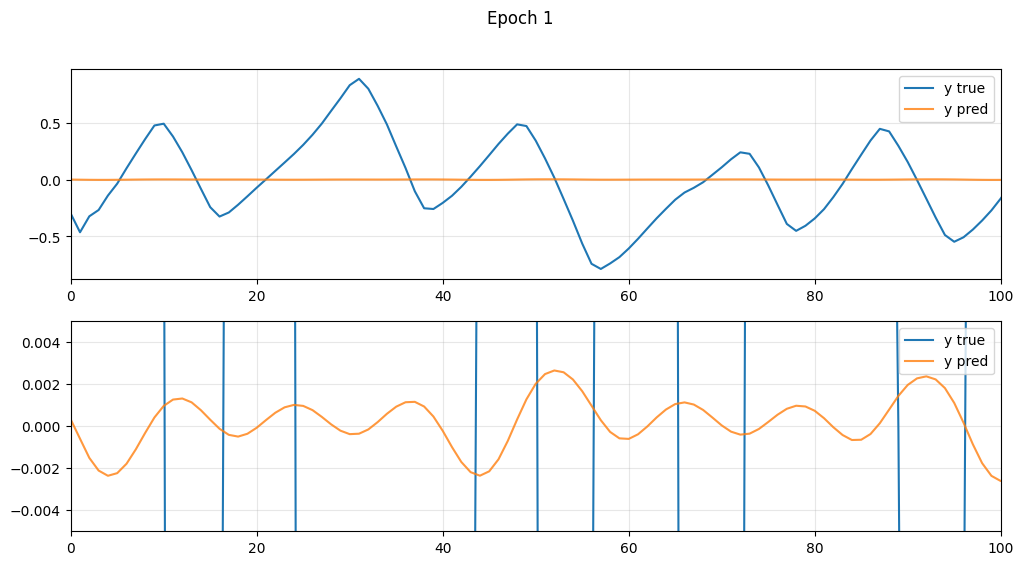

Training:   1%|          | 2/200 [01:03<1:44:42, 31.73s/it]

Epoch    2 | train 0.158665 | val 0.157571 | lr 1.00e-03


Training:   2%|▏         | 3/200 [01:35<1:43:56, 31.66s/it]

Epoch    3 | train 0.158664 | val 0.157561 | lr 9.99e-04


Training:   2%|▏         | 4/200 [02:06<1:42:47, 31.47s/it]

Epoch    4 | train 0.158664 | val 0.157556 | lr 9.99e-04


Training:   2%|▎         | 5/200 [02:37<1:42:04, 31.41s/it]

Epoch    5 | train 0.158658 | val 0.157555 | lr 9.98e-04


Training:   3%|▎         | 6/200 [03:09<1:41:28, 31.38s/it]

Epoch    6 | train 0.158658 | val 0.157555 | lr 9.98e-04


Training:   4%|▎         | 7/200 [03:40<1:40:41, 31.30s/it]

Epoch    7 | train 0.158658 | val 0.157555 | lr 9.97e-04


Training:   4%|▍         | 8/200 [04:11<1:39:57, 31.24s/it]

Epoch    8 | train 0.158658 | val 0.157555 | lr 9.96e-04


Training:   4%|▍         | 9/200 [04:42<1:39:21, 31.21s/it]

Epoch    9 | train 0.158657 | val 0.157554 | lr 9.95e-04
Epoch   10 | train 0.158658 | val 0.157555 | lr 9.94e-04
alpha (scale needed): -1.2699265480041504


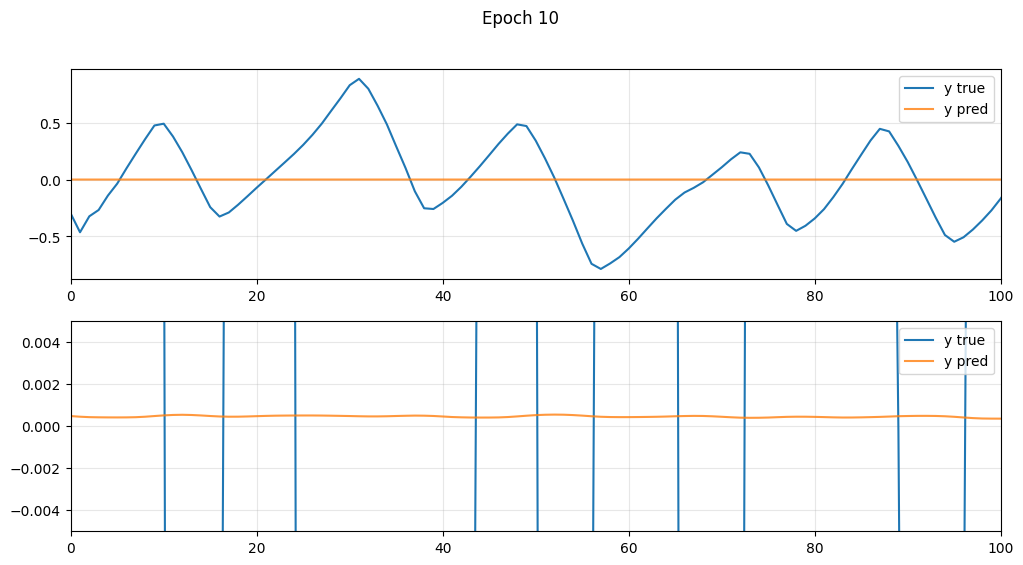

Training:   6%|▌         | 11/200 [05:45<1:39:00, 31.43s/it]

Epoch   11 | train 0.158659 | val 0.157557 | lr 9.93e-04


Training:   6%|▌         | 12/200 [06:17<1:38:38, 31.48s/it]

Epoch   12 | train 0.158659 | val 0.157557 | lr 9.91e-04


Training:   6%|▋         | 13/200 [06:48<1:37:59, 31.44s/it]

Epoch   13 | train 0.158658 | val 0.157557 | lr 9.90e-04


Training:   7%|▋         | 14/200 [07:19<1:37:14, 31.37s/it]

Epoch   14 | train 0.158658 | val 0.157557 | lr 9.88e-04


Training:   8%|▊         | 15/200 [07:51<1:36:54, 31.43s/it]

Epoch   15 | train 0.158657 | val 0.157557 | lr 9.86e-04


Training:   8%|▊         | 16/200 [08:22<1:36:35, 31.50s/it]

Epoch   16 | train 0.158658 | val 0.157559 | lr 9.84e-04


Training:   8%|▊         | 17/200 [08:54<1:36:33, 31.66s/it]

Epoch   17 | train 0.158663 | val 0.157556 | lr 9.82e-04


Training:   9%|▉         | 18/200 [09:26<1:35:51, 31.60s/it]

Epoch   18 | train 0.158658 | val 0.157556 | lr 9.80e-04


Training:  10%|▉         | 19/200 [09:57<1:35:15, 31.58s/it]

Epoch   19 | train 0.158657 | val 0.157556 | lr 9.78e-04


Training:  10%|▉         | 19/200 [10:28<1:39:44, 33.07s/it]


KeyboardInterrupt: 

In [ ]:

@dataclass
class TrainConfig:
    epochs: int = 200
    lr: float = 1e-3
    weight_decay: float = 1e-6
    grad_clip: float = None
    seed: int = 42

cfg_train = TrainConfig()

torch.manual_seed(cfg_train.seed)
np.random.seed(cfg_train.seed)
random.seed(cfg_train.seed)

criterion = nn.MSELoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=cfg_train.lr, weight_decay=cfg_train.weight_decay)
optimizer = torch.optim.AdamW([
    {"params": model.base.parameters(), "lr": cfg_train.lr, "weight_decay": cfg_train.weight_decay},
    {"params": [model.log_gain, model.sign_raw], "lr": 1e-2, "weight_decay": 0.0},
])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg_train.epochs)

def run_epoch(model, loader, train: bool):
    model.train(train)
    total, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = criterion(pred, yb)
        if train:
            loss.backward()
            if cfg_train.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg_train.grad_clip)
            optimizer.step()
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / max(1, n)

@torch.no_grad()
def visualize_predictions(model, loader, n_show=2, title="Predictions", max_points=6000):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    yb = yb.to(device)
    pred = model(xb).detach().cpu().numpy()
    yb = yb.detach().cpu().numpy()

    num = (pred * yb).sum()
    den = (pred * pred).sum() + 1e-12
    alpha = (num / den).item()
    print("alpha (scale needed):", alpha)

    plt.figure(figsize=(12, 3*n_show))
    for i in range(min(n_show, pred.shape[0])):
        T = pred.shape[-1]
        step = max(1, T // max_points)
        plt.subplot(n_show, 1, i+1)
        plt.plot(yb[i,0,::step], label="y true")
        plt.plot(pred[i,0,::step], label="y pred", alpha=0.8)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 100)
    plt.suptitle(title)
    plt.ylim(-0.005, 0.005)
    plt.show()

history = {"train": [], "val": []}

for epoch in tqdm(range(1, cfg_train.epochs + 1), desc="Training"):
    train_loss = run_epoch(model, dl_train, train=True)
    val_loss   = run_epoch(model, dl_val, train=False)
    scheduler.step()

    history["train"].append(train_loss)
    history["val"].append(val_loss)

    print(f"Epoch {epoch:4d} | train {train_loss:.6f} | val {val_loss:.6f} | lr {scheduler.get_last_lr()[0]:.2e}")
    if epoch == 1 or epoch % 10 == 0:
        visualize_predictions(model, dl_val, n_show=2, title=f"Epoch {epoch}")

plt.figure(figsize=(10, 3))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Loss curves")
plt.show()


In [ ]:
@torch.no_grad()
def debug_scale(model, loader):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device); yb = yb.to(device)
    pred = model(xb)

    yt = yb[:,0,:].reshape(-1)
    yp = pred[:,0,:].reshape(-1)

    rms_y  = torch.sqrt(torch.mean(yt**2)).item()
    rms_p  = torch.sqrt(torch.mean(yp**2)).item()
    corr   = ( (yt-yt.mean())*(yp-yp.mean()) ).mean() / (yt.std()*yp.std() + 1e-12)

    alpha = ( (yp*yt).sum() / ( (yp*yp).sum() + 1e-12) ).item()  # your scale-needed

    print("rms_true:", rms_y, "rms_pred:", rms_p, "rms_ratio pred/true:", rms_p/(rms_y+1e-12))
    print("corr:", corr.item() if hasattr(corr, "item") else float(corr))
    print("alpha (true ≈ alpha*pred):", alpha)

debug_scale(model, dl_val)


## 9) Test evaluation

In [ ]:

test_loss = run_epoch(model, dl_test, train=False)
print("Test MSE:", test_loss)
visualize_predictions(model, dl_test, n_show=3, title="Test predictions")


## 10) Save model + configs + train-only norm stats

In [ ]:

OUT_DIR = Path("./outputs_fno1d")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = OUT_DIR / "fno1d_x_to_y.pt"
torch.save(model.state_dict(), ckpt_path)

cfg_path = OUT_DIR / "config.json"
bundle = {
    "split": asdict(cfg_split),
    "preproc": asdict(cfg_prep),
    "model": asdict(cfg_model),
    "train": asdict(cfg_train),
    "meta": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in meta.items()},
    "fs": fs,
    "seg_dur_sec": SEG_DUR_SEC,
}
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(bundle, f, indent=2, ensure_ascii=False)

stats_path = OUT_DIR / "norm_stats_train_only.npz"
if norm_stats is not None:
    np.savez(stats_path, **{k: v for k, v in norm_stats.items() if isinstance(v, np.ndarray)},
             mode=norm_stats.get("mode", "none"))
else:
    np.savez(stats_path, mode="none")

print("Saved:")
print(" -", ckpt_path)
print(" -", cfg_path)
print(" -", stats_path)
